In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import sys,os
sys.path.append(os.path.expanduser('~')+'work'+os.path.sep+'common_libraries')
import graphs.my_graph as my_graph
import data_analysis.signanalysis as signanalysis
%load_ext autoreload
%autoreload 2 # enable reloading|
from IPython.display import Image

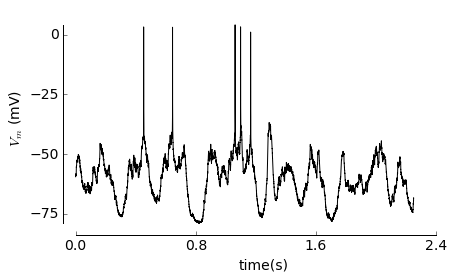

In [215]:
# Starting from the raw data ...
dt=1./(50.e3) # 50kHz samplings 
Vm = np.array(np.load('sample_up_down.npz')['v1'])
t = np.arange(len(Vm))*dt
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(t, Vm, 'k-')
my_graph.set_plot(ax, xlabel='time(s)', ylabel='$V_m$ (mV)')
# we smooth a bit
t_smooth = 2e-4 # 0.2ms gaussian smoothing
Vm = signanalysis.gaussian_smoothing(Vm, idt_sbsmpl=int(t_smooth/dt))

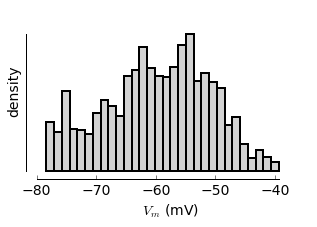

In [216]:
# first we cut spikes
threshold = -40
Vm = np.array(Vm[Vm<threshold])
dVm = 1e-3*np.diff(Vm)/dt #signanalysis.gaussian_smoothing(1e-3*np.diff(Vm2)/dt)
t = np.arange(len(Vm))*dt
# and we plot the disctribution
hist, bin_edges = np.histogram(Vm, bins=30, normed=True)
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist, width=bin_edges[1]-bin_edges[0],\
color='lightgray', edgecolor='k', lw=2)
my_graph.set_plot(ax, yticks=[], xlabel='$V_m$ (mV)', ylabel='density')

0.861483 0.849478
0.671926 0.572422


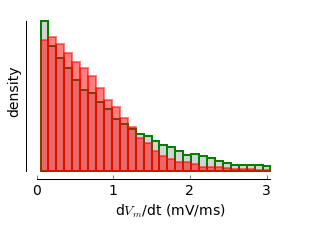

In [219]:
# first we cut spikes
dVm = 1e-3*np.diff(Vm)/dt
t = np.arange(len(Vm))[1:]*dt
Vm = Vm[1:]
bins= np.linspace(0,3,30)
# and we plot the disctribution
hist1, bin_edges = np.histogram(dVm[dVm>0], bins=bins, normed=True)
hist2, bin_edges = np.histogram(np.abs(dVm[dVm<0]), bins=bins, normed=True)
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist1, width=bin_edges[1]-bin_edges[0],\
    color='lightgray', edgecolor='g', lw=2)
plt.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist2, width=bin_edges[1]-bin_edges[0],\
    color='r', edgecolor='r', lw=2, alpha=.5)
my_graph.set_plot(ax, yticks=[], xlabel='d$V_m$/dt (mV/ms)', ylabel='density')
print(np.mean(dVm[dVm>0]), np.std(dVm[dVm>0]))
print(np.mean(np.abs(dVm[dVm<0])), np.std(np.abs(dVm[dVm<0])))

In [220]:
# focusing on the first 100ms
t1, t2 = 0.4, 0.6#1.3, 1.5
Vm2 = Vm[(t<t2) & (t>=t1)]
dVm2 = dVm[(t<t2) & (t>=t1)]
t2 = t[(t<t2) & (t>=t1)]

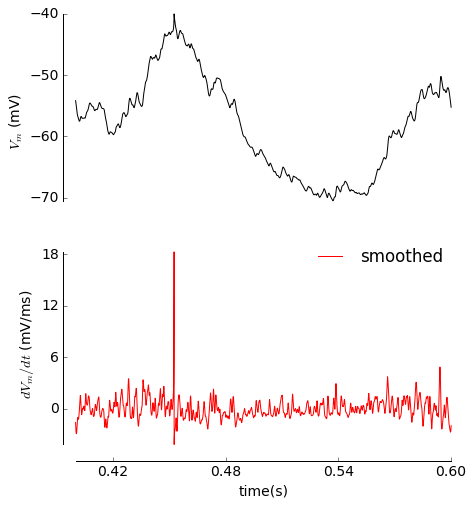

In [223]:

fig, [ax1,ax2] = plt.subplots(2,figsize=(7,8));plt.subplots_adjust(hspace=0.)
ax1.plot(t2, Vm2, 'k-')
ax2.plot(t2, dVm2, 'r-', label='smoothed')
ax2.legend(frameon=False)
my_graph.set_plot(ax1, ['left'], ylabel='$V_m$ (mV)', xticks=[])
my_graph.set_plot(ax2, xlabel='time(s)', ylabel='$dV_m/dt$ (mV/ms)')

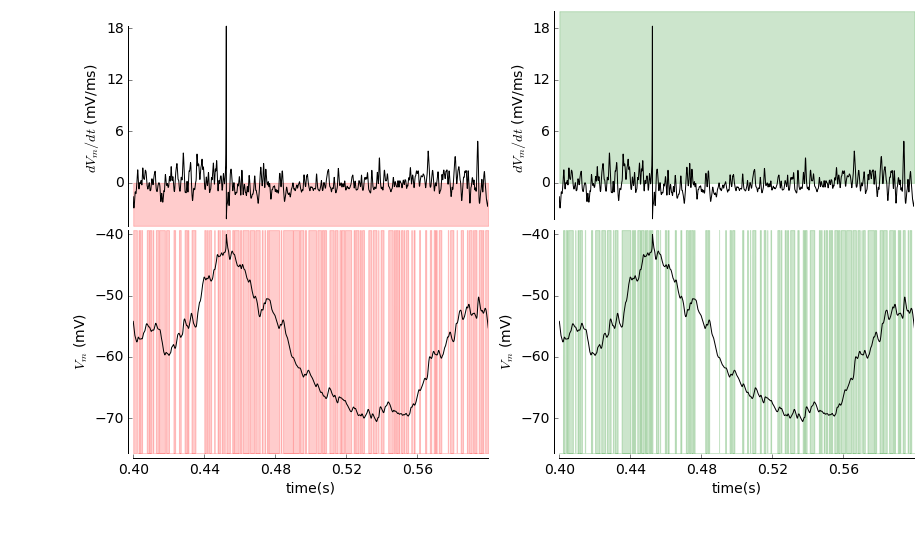

In [244]:
def find_intervals_of_hyperpolarization(dVm):
    i_start_hyperpol = np.argwhere((dVm[1:]<0) & (dVm[:-1]>=0)).flatten()
    i_end_hyperpol = np.argwhere((dVm[1:]>0) & (dVm[:-1]<=0)).flatten()
    # we want to start with 
    if i_start_hyperpol[0]<i_end_hyperpol[0]:
       i_start_hyperpol = i_start_hyperpol[:len(i_end_hyperpol)] 
    else:
       i_end_hyperpol = i_end_hyperpol[1:len(i_start_hyperpol)] 
    return[[i0, i1] for i0, i1 in zip(i_start_hyperpol, i_end_hyperpol)]

def find_intervals_of_depolarization(dVm):
    i_start_depol = np.argwhere((dVm[1:]>=0) & (dVm[:-1]<0)).flatten()
    i_end_depol = np.argwhere((dVm[1:]<=0) & (dVm[:-1]>0)).flatten()
    # we want to start with 
    if i_start_depol[0]<i_end_depol[0]:
       i_start_depol = i_start_depol[:len(i_end_depol)] 
    else:
       i_end_depol = i_end_depol[1:len(i_start_depol)] 
    return[[i0, i1] for i0, i1 in zip(i_start_depol, i_end_depol)]

HPintervals = find_intervals_of_hyperpolarization(dVm2)
DPintervals = find_intervals_of_depolarization(dVm2)

fig, [[ax1,ax3],[ax2,ax4]] = plt.subplots(2,2,figsize=(14,8));plt.subplots_adjust(hspace=0.)

# HYPERPOLARIZATION
ax1.plot(t2, dVm2, 'k-', label='smoothed')
ax1.annotate('hyperpolarization', (0., ax1.get_ylim()[0]))
ax1.fill_between(t2, 0.*t2, ax1.get_ylim()[0]+0.*t2, color='r', alpha=.2)
my_graph.set_plot(ax1, ['left'], ylabel='$dV_m/dt$ (mV/ms)', xticks=[], xlim=[t2[0],t2[-1]])
# identify hyperpolarizations
ihp = np.argwhere(dVm2<0).flatten()
ax2.plot(t2, Vm2, 'k-')
my_graph.set_plot(ax2, xlabel='time(s)', ylabel='$V_m$ (mV)', xlim=[t2[0],t2[-1]])
for i0, i1 in HPintervals:
     ax2.fill_between([t2[i0], t2[i1]], ax2.get_ylim()[0], ax2.get_ylim()[0], color='r', alpha=.2)
hp_times = np.zeros(len(t2))+ax2.get_ylim()[0]
hp_times[ihp] = ax2.get_ylim()[1]
ax2.fill_between(t2, 0.*t2+ax2.get_ylim()[0], hp_times, color='r', alpha=.2)

# DEPOLARIZATION
ax3.plot(t2, dVm2, 'k-', label='smoothed')
ax3.annotate('depolarization', (0., ax1.get_ylim()[0]))
ax3.fill_between(t2, 0.*t2, ax3.get_ylim()[1]+0.*t2, color='g', alpha=.2)
my_graph.set_plot(ax3, ['left'], ylabel='$dV_m/dt$ (mV/ms)', xticks=[], xlim=[t2[0],t2[-1]])
# identify hyperpolarizations
idp = np.argwhere(dVm2>0).flatten()
ax4.plot(t2, Vm2, 'k-')
my_graph.set_plot(ax4, xlabel='time(s)', ylabel='$V_m$ (mV)', xlim=[t2[0],t2[-1]])
for i0, i1 in DPintervals:
     ax4.fill_between([t2[i0], t2[i1]], ax4.get_ylim()[0], ax4.get_ylim()[0], color='g', alpha=.2)
dp_times = np.zeros(len(t2))+ax4.get_ylim()[0]
dp_times[idp] = ax4.get_ylim()[1]
ax4.fill_between(t2, 0.*t2+ax4.get_ylim()[0], dp_times, color='g', alpha=.2)

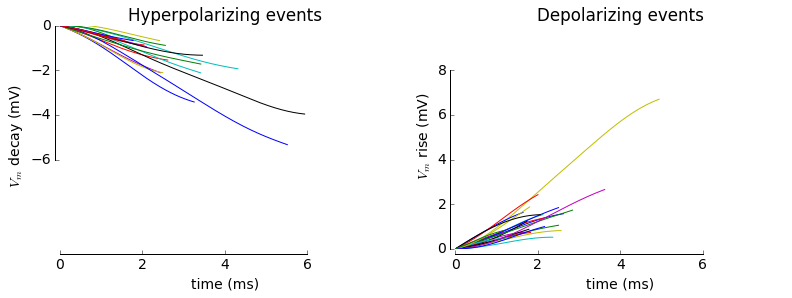

In [245]:
from scipy import stats

def get_time_constants(intervals, Vm, t, sign=-1, ax1=None, tsmooth=1e-3, min_deflection=0.5):
    """
    we divide the deflections in segments of "min_deflection" and we calculate what is the time to achieve this
    mean deflection 
    """
    Vm2 = signanalysis.gaussian_smoothing(Vm, idt_sbsmpl=int(tsmooth/(t[1]-t[0])))
    Depol, Tcst, Vlevel = [], [], []
    for (i0, i1) in intervals[:-1]:
        xx = 1e3*(t[i0+1:i1]-t[i0])
        #tt, vv = np.log(xx)/np.log(10), Vm2[i0+1:i1]
        DT = 1e3*(t[i1]-t[i0])
        nvv, dv = (vv-vv.min())/(vv.max()-vv.min()), (vv.max()-vv.min())
        dv = Vm2[i1]-Vm2[i0]
        if sign*dv>min_deflection:
            slope, intercept, r_value, p_value, std_err = stats.linregress(1e3*(t[i0:i1]-t[i0]), Vm2[i0:i1])
            Tcst.append(1e-3*np.mean(np.diff(Vm2[i0:i1])/dt))
            Depol.append(dv)
            Vlevel.append(Vm2[i0])
            if ax1 is not None:
                ax1.plot(1e3*(t[i0+1:i1]-t[i0]), Vm2[i0+1:i1]-Vm2[i0])
    return np.abs(Tcst), Depol, Vlevel

fig, [ax1,ax2] = plt.subplots(1, 2,figsize=(13,4))
TcstHP, DepolHP, VlevelHP = get_time_constants(HPintervals, Vm2, t2, ax1=ax1, tsmooth=1e-3)
TcstDP, DepolDP, VlevelDP = get_time_constants(DPintervals, Vm2, t2, sign=1, ax1=ax2, tsmooth=1e-3)
ax1.set_title('Hyperpolarizing events')
my_graph.set_plot(ax1, ylabel=' $V_m$ decay (mV)', xlabel='time (ms)', xlim=[0,8], ylim=[-10,0])
ax2.set_title('Depolarizing events')
my_graph.set_plot(ax2, ylabel=' $V_m$ rise (mV)', xlabel='time (ms)', xlim=[0,8], ylim=[0,10])

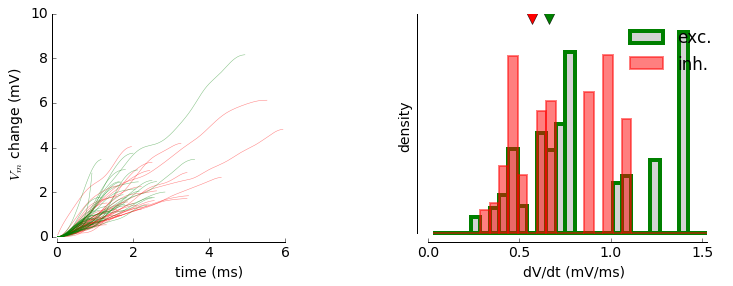

In [246]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,4))

for intervals, col, sign in zip([HPintervals, DPintervals], ['r','g'], [-1,1]):
    for (i0, i1) in intervals[:-1]:
        xx = 1e3*(t2[i0+1:i1]-t2[i0])
        dv = Vm2[i1]-Vm2[i0]
        if sign*dv>0.5:
            ax1.plot(1e3*(t2[i0+1:i1]-t2[i0]), sign*(Vm2[i0+1:i1]-Vm2[i0]), color=col, lw=.5, alpha=.5)

my_graph.set_plot(ax1, ylabel=' $V_m$ change (mV)', xlabel='time (ms)', xlim=[0,8], ylim=[0,10])

bins= np.linspace(0,1.5,30)
# and we plot the disctribution
hist1, bin_edges = np.histogram(TcstDP, bins=bins, normed=True, weights=np.abs(DepolDP))
hist2, bin_edges = np.histogram(TcstHP, bins=bins, normed=True, weights=np.abs(DepolHP))
ax2.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist1, width=bin_edges[1]-bin_edges[0],\
    color='lightgray', edgecolor='g', lw=4, label='exc.')
ax2.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist2, width=bin_edges[1]-bin_edges[0],\
    color='r', edgecolor='r', lw=2, alpha=.5, label='inh.')
my_graph.set_plot(ax2, yticks=[], xlabel='dV/dt (mV/ms)', ylabel='density')
ax2.plot([np.mean(TcstHP)], [ax2.get_ylim()[1]], 'v', color='r', ms=20)
ax2.plot([np.mean(TcstDP)], [ax2.get_ylim()[1]], 'v', color='g', ms=20)
ax2.legend(frameon=False)

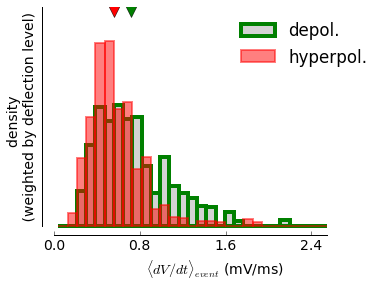

In [247]:
# for all data now
HPintervals = find_intervals_of_hyperpolarization(dVm)
DPintervals = find_intervals_of_depolarization(dVm)
TcstHP, DepolHP, VlevelHP = get_time_constants(HPintervals, Vm, t, tsmooth=1e-3)
TcstDP, DepolDP, VlevelDP = get_time_constants(DPintervals, Vm, t, sign=1, tsmooth=1e-3)

fig, ax2 = plt.subplots(1, figsize=(6,4))
bins= np.linspace(0,2.5,30)
# and we plot the disctribution
hist1, bin_edges = np.histogram(TcstDP, bins=bins, normed=True, weights=np.abs(VlevelDP))
hist2, bin_edges = np.histogram(TcstHP, bins=bins, normed=True, weights=np.abs(VlevelHP))
ax2.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist1, width=bin_edges[1]-bin_edges[0],\
    color='lightgray', edgecolor='g', lw=4, label='depol.')
ax2.bar(.5*(bin_edges[1:]+bin_edges[:-1]), hist2, width=bin_edges[1]-bin_edges[0],\
    color='r', edgecolor='r', lw=2, alpha=.5, label='hyperpol.')
my_graph.set_plot(ax2, yticks=[], xlabel=r'$\langle dV/dt \rangle_{event}$ (mV/ms)',\
ylabel='density \n (weighted by deflection level)')
ax2.plot([np.mean(TcstHP)], [ax2.get_ylim()[1]], 'v', color='r', ms=20)
ax2.plot([np.mean(TcstDP)], [ax2.get_ylim()[1]], 'v', color='g', ms=20)
ax2.legend(frameon=False)

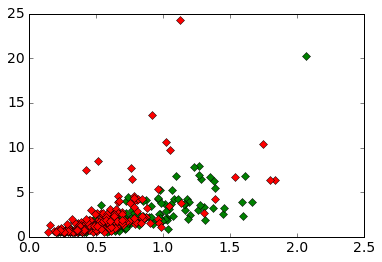

In [251]:
plt.plot(TcstDP, np.abs(DepolDP), 'gD')
plt.plot(TcstHP, np.abs(DepolHP), 'rD')

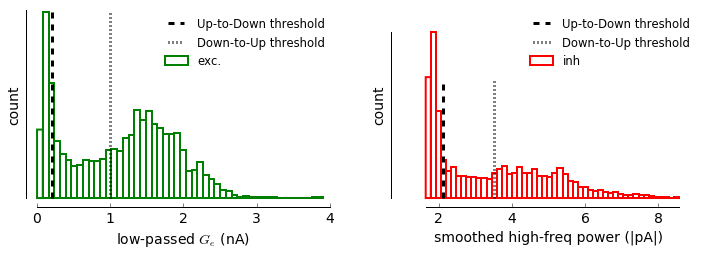

In [8]:
# thresholds for up and down states detections
UD_tvfa_exc_threshold = 0.2
DU_tvfa_exc_threshold = 1.
UD_tvfa_inh_threshold = 2.1
DU_tvfa_inh_threshold = 3.5

# histogram of time varying fluctuations

fig, AX = plt.subplots(1,2,figsize=(12,3.5))

AX[0].hist(Gexc_LP, bins=50, color='b', label='exc.', facecolor='w', edgecolor='g', lw=2)
AX[0].plot([UD_tvfa_exc_threshold,UD_tvfa_exc_threshold], [0, AX[0].get_ylim()[1]], 'k--', lw=3, label='Up-to-Down threshold')
AX[0].plot([DU_tvfa_exc_threshold,DU_tvfa_exc_threshold], [0, AX[0].get_ylim()[1]], 'k:', lw=3, label='Down-to-Up threshold')
my_graph.set_plot(AX[0], xlabel='low-passed $G_e$ (nA)', ylabel='count', yticks=[])

AX[1].hist(Iinh_LP2, bins=50, label='inh', facecolor='w', edgecolor='r', lw=2)
AX[1].plot([UD_tvfa_inh_threshold,UD_tvfa_inh_threshold], [0, AX[0].get_ylim()[1]], 'k--', lw=3, label='Up-to-Down threshold')
AX[1].plot([DU_tvfa_inh_threshold,DU_tvfa_inh_threshold], [0, AX[0].get_ylim()[1]], 'k:', lw=3, label='Down-to-Up threshold')
my_graph.set_plot(AX[1], xlabel='smoothed high-freq power (|pA|)', ylabel='count', yticks=[])

for ax in AX: ax.legend(frameon=False, prop={'size':'small'})
    

In [9]:
# functions for identifying up and down states
    
def get_time_varying_fluct_amplitude(signal, idt_sbsmpl=int(50e-3/dt)):
    """
    computes the time-varying fluctuation amplitude
    the fluctuations are evaluated over a window of size *idt_sbsmpl* (i.e. in index values)
    """
    tvfa = 0.*signal # time varying fluctuation amplitude
    for i in range(len(signal)):
        tvfa[i] = np.std(signal[np.max([0,i-idt_sbsmpl]):np.min([len(signal)-1,i+idt_sbsmpl])])
    return tvfa

def get_up_and_down_states_intervals(signal, UD_threshold, DU_threshold,):
    """
    Up states are defined as periods of strong fluctuations, Down states -> low fluctuations
    we return the signal samples of Up state and the signal samples of Down state
    """
    i_down, i_up, Signals_samples_up, Signals_samples_down = [], [], [], []
    i_up_start, i_down_end, i_down_start, i_up_end = 0, 0, 0, 0
    up_flag = True
    if signal[0]<=DU_threshold: up_flag=False
    for i in range(1,len(signal)):
        if (signal[i]>DU_threshold) and (signal[i-1]<=DU_threshold) and not up_flag:
            # fluctuation increase -> Down-to-Up transition
            i_up_start, i_down_end = i-int(1/(lowcut*dt)), i
            i_down.append([i_down_start,i_down_end])
            up_flag = True
        if (signal[i]<UD_threshold) and (signal[i-1]>=UD_threshold) and up_flag:
            # fluctuation decrease -> Up-to-Down transition
            i_down_start, i_up_end = i-int(1/(lowcut*dt)), i
            i_up.append([i_up_start,i_up_end])
            up_flag = False
    return i_up, i_down

In [10]:
# computing the Up and Down states samples based on the fluctuations criteria...

# --> excitatory currents
Exc_i_up, Exc_i_down = get_up_and_down_states_intervals(Gexc_LP, UD_tvfa_exc_threshold, DU_tvfa_exc_threshold)
# --> inhibitory currents
Inh_i_up, Inh_i_down = get_up_and_down_states_intervals(Iinh_LP2, UD_tvfa_inh_threshold, DU_tvfa_inh_threshold)

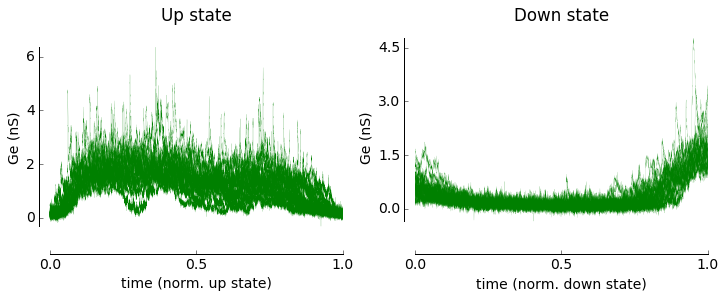

In [11]:
# Excitatory currents

fig, AX = plt.subplots(1, 2, figsize=(12,4))
# Up state
AX[0].set_title('Up state')
for (i0,i1) in Exc_i_up[1:-1]:
    AX[0].plot(np.linspace(0,1,i1-i0), Gexc[i0:i1], 'g', lw=.1)
my_graph.set_plot(AX[0], xlabel='time (norm. up state)', ylabel='Ge (nS)', xticks=[0,0.5,1.])
# Down state
AX[1].set_title('Down state')
for (i0,i1) in Exc_i_down[1:-1]:
    AX[1].plot(np.linspace(0,1,i1-i0), Gexc[i0:i1], 'g', lw=.1)
my_graph.set_plot(AX[1], xlabel='time (norm. down state)', ylabel='Ge (nS)', xticks=[0,0.5,1.])

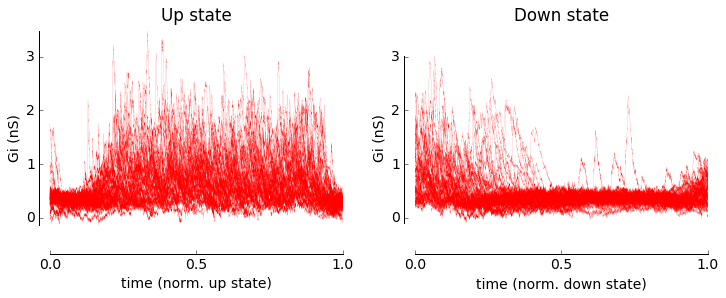

In [12]:
# Inhibitory currents

fig, AX = plt.subplots(1, 2, figsize=(12,4))
# Up state
AX[0].set_title('Up state')
for (i0,i1) in Inh_i_up[1:-1]:
    AX[0].plot(np.linspace(0,1,i1-i0), Ginh[i0:i1], 'r', lw=.1)
my_graph.set_plot(AX[0], xlabel='time (norm. up state)', ylabel='Gi (nS)', xticks=[0,0.5,1.])
# Down state
AX[1].set_title('Down state')
for (i0,i1) in Inh_i_down[1:-1]:
    AX[1].plot(np.linspace(0,1,i1-i0), Ginh[i0:i1], 'r', lw=.1)
my_graph.set_plot(AX[1], xlabel='time (norm. down state)', ylabel='Gi (nS)', xticks=[0,0.5,1.])

In [13]:
# Comparing the excitation and inhibition along the two state, analogous to Neske et al. J. Neurosci. 2015

discret = 100 # we need to have the same discretization for all samples to compare them
t = np.linspace(0,1,discret)

# Excitatory Currents
Gexc_up, Gexc_down = np.zeros((len(t), len(Exc_i_up[1:-1]))), np.zeros((len(t), len(Exc_i_down[1:-1])))
for j, (i0,i1) in zip(range(len(Exc_i_up[1:-1])), Exc_i_up[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Gexc_up[:,j] = [Gexc[i0:i1][resampling_indexes==k].mean() for k in range(discret)]
for j, (i0,i1) in zip(range(len(Exc_i_down[1:-1])), Exc_i_down[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Gexc_down[:,j] = [Gexc[i0:i1][resampling_indexes==k].mean() for k in range(discret)]

# Inhibitory currents
Ginh_up, Ginh_down = np.zeros((len(t), len(Inh_i_up[1:-1]))), np.zeros((len(t), len(Inh_i_down[1:-1])))
for j, (i0,i1) in zip(range(len(Inh_i_up[1:-1])), Inh_i_up[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Ginh_up[:,j] = [Ginh[i0:i1][resampling_indexes==k].mean() for k in range(discret)]
for j, (i0,i1) in zip(range(len(Inh_i_down[1:-1])), Inh_i_down[1:-1]):
    resampling_indexes = np.arange(discret)[np.array(np.arange(i1-i0)/(i1-i0)*discret, dtype=int)]
    Ginh_down[:,j] = [Ginh[i0:i1][resampling_indexes==k].mean() for k in range(discret)]

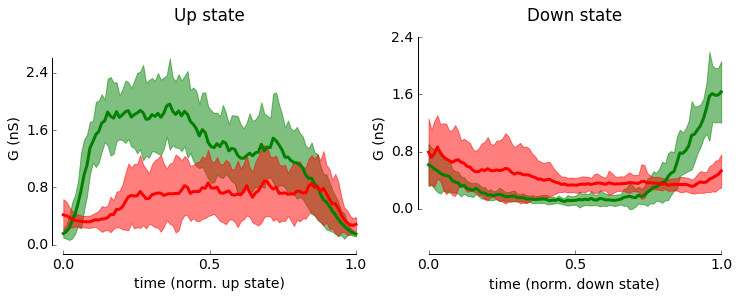

In [15]:
# plotting

fig, AX = plt.subplots(1, 2, figsize=(12,4))
# Up state
AX[0].set_title('Up state')
AX[0].plot(np.linspace(0,1,discret), Gexc_up.mean(axis=-1), 'g-', lw=3)
AX[0].fill_between(np.linspace(0,1,discret), Gexc_up.mean(axis=-1)-Gexc_up.std(axis=-1),\
           Gexc_up.mean(axis=-1)+Gexc_up.std(axis=-1), color='g', alpha=.5)
AX[0].plot(np.linspace(0,1,discret), Ginh_up.mean(axis=-1), 'r-', lw=3)
AX[0].fill_between(np.linspace(0,1,discret), Ginh_up.mean(axis=-1)-Ginh_up.std(axis=-1),\
           Ginh_up.mean(axis=-1)+Ginh_up.std(axis=-1), color='r', alpha=.5)
my_graph.set_plot(AX[0], xlabel='time (norm. up state)', ylabel='G (nS)', xticks=[0,0.5,1.])
# Down state
AX[1].set_title('Down state')
AX[1].plot(np.linspace(0,1,discret), Gexc_down.mean(axis=-1), 'g-', lw=3)
AX[1].fill_between(np.linspace(0,1,discret), Gexc_down.mean(axis=-1)-Gexc_down.std(axis=-1),\
           Gexc_down.mean(axis=-1)+Gexc_down.std(axis=-1), color='g', alpha=.5)
AX[1].plot(np.linspace(0,1,discret), Ginh_down.mean(axis=-1), 'r-', lw=3)
AX[1].fill_between(np.linspace(0,1,discret), Ginh_down.mean(axis=-1)-Ginh_down.std(axis=-1),\
           Ginh_down.mean(axis=-1)+Ginh_down.std(axis=-1), color='r', alpha=.5)
my_graph.set_plot(AX[1], xlabel='time (norm. down state)', ylabel='G (nS)', xticks=[0,0.5,1.])
fig.savefig('figs/average_conductances.png')

## For a comparison let's have a look at the _in vitro_ results of Neske 2015

<img src="figs/neske.png",width=400>

Note that the variations are variations over cycles in our case whereas it is variations over cells after computing the mean for each cell in the Neske et al. case


But something is striking from the raw traces


## **The mean-to-fluctuations ratio is very different in between excitation and inhibition !**

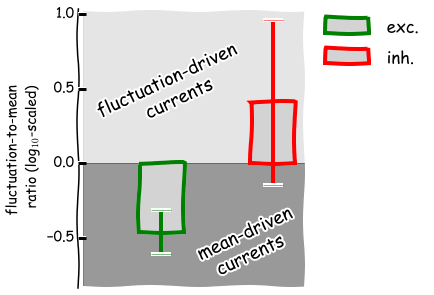

In [16]:
# means estimated on centers of identified states and with respect to down states levels
means_exc = Gexc_up[25:75,:].mean(axis=0)-Gexc_down[25:75,:].mean() 
means_inh = Ginh_up[25:75,:].mean(axis=0)-Ginh_down[25:75,:].mean()
# same for fluctuations, evaluated on center !
fluct_exc = Gexc_up[25:75,:].std(axis=0)
fluct_inh = Ginh_up[25:75,:].std(axis=0)
Ie_ratio = np.mean(fluct_exc/means_exc)
Ii_ratio = np.mean(fluct_inh/means_inh)

# simple estimate of the variability for the log plot (to be polished !)
Ie_std = np.log(Ie_ratio+np.std(fluct_exc/means_exc))/np.log(10)-np.log(Ie_ratio)/np.log(10)
Ii_std = np.log(Ii_ratio+np.std(fluct_inh/means_inh))/np.log(10)-np.log(Ii_ratio)/np.log(10)

with plt.xkcd():
    plt.rcParams.update({'font.size': 18})

    fig, ax = plt.subplots(1, figsize=(4,5))
    bar1 = my_graph.add_errorbar(ax, 0, np.log(Ie_ratio)/np.log(10),\
                          Ie_std, color='g', width=.4)
    bar2 = my_graph.add_errorbar(ax, 1, np.log(Ii_ratio)/np.log(10),\
                          Ii_std, color='r', width=.4)
    my_graph.set_plot(ax, ['left'], xticks=[], xlim=[-.5,1.5],\
                     ylabel='fluctuation-to-mean \n ratio (log$_{10}$-scaled)')
    ax.fill_between(ax.get_xlim(), [0,0], [ax.get_ylim()[1],ax.get_ylim()[1]], color='k', alpha=.1)
    text1 = ax.annotate("fluctuation-driven \n        currents", xy=(-.4, .6))
    ax.fill_between(ax.get_xlim(), [0,0], [ax.get_ylim()[0],ax.get_ylim()[0]], color='k', alpha=.4)
    text2 = ax.annotate("mean-driven \n  currents", xy=(.5, -.5))
    ax.legend([bar1, bar2], ['exc.', 'inh.'], frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    for text in [text1, text2]: text.set_rotation(25)
    fig.savefig('figs/current_picture.png')

# Asynchronous dynamics in neocortical networks 

### Theoretical perspective

### Pioneering theoretical work  [Van Vreeswijk and Sompolinsky, Science 1996](http://science.sciencemag.org/content/274/5293/1724.long):

  Neocortical networks display a chaotic state, where, because of the excitatory/inhibitory recurrent architecture of cortical assemblies, the activity can be _**balanced**_. In this setting, the mean excitatory and inhibitory network activity settles the membrane polarization sightly below spiking threshold and single cell firing happens because of fluctuations. Illustrated on Figure 1 in the paper:
<img src="figs/vw_somp_1996.png",width=300>
  Thus, for a single cell, if its presynaptic activity exhibits irregular spiking, its output firing will also be irregular in this setting.  
  $\Rightarrow$ At the network level there exist an asynchronous dynamical state where all neurons fire irregularly (recurrent interactions promote dynamical regime where single cells exhibit self-consistent behaviors)  

But this scenario is valid only in sparsely connected networks, where neurons share a weak number of common synapses (to insure asynchronicity among neurons) and where current fluctuations remain of large amplitude (if neurons have too many synapses, the law of large numbers applies and makes the fluctuations very low with respect to their mean, what would require a fine-tuning of the depolarization level with respect to the threshold to be sensitive to fluctuations)

### Alternative theory for densely connected networks [Renart et al., Science 2010](http://science.sciencemag.org/content/327/5965/587)

Asynchronous dynamics (spontaneous activity of arbitrary low correlation between pairwise spiking) emerges as a consequence of an **active decorrelation** mechanism in balanced recurrent networks, excitatory current and inhibitory current

<img src="figs/Renart.png",width=700>

## In general other conductances measurements

#### Haider et al., J. Neurosci. 2006

<img src="figs/Haider2006.png",width=600>

## In general other conductances measurements

#### Haider et al., Nature 2013

<img src="figs/Haider2013.png",width=700>

# Questions to be answered

- How can there be a stable ongoing dynamics without balanced inhibition ?  


- How are affected the integrative properties of neural networks in the non-balanced case ? (linearization of responses to afferent inputs, fast-tracking of input temporal modulations, etc..)  


- Conductance measurements seems to give a bit a different answer in higher mammals (e.g. cat), does this picture only applies to rodent neocortex ?  



# Clues/hints for a novel dynamical regime

- Excitatory currents and inhibitory currents are qualitatively different, excitation is mean-driven, inhibition is fluctuation-driven  


- Activity is very sparse, the synaptic bombardment is not that massive... no very strong conductance changes  


- Neurons share much of the excitation and much fewer of the inhibition, so that their subthreshold $V_m$ can be correlated across neurons (Poulet & Petersen, Nature 2008) while their spiking remains irregular ()  


